In [30]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

In [31]:
def logistic(z):
    return 1. / (1. + nd.exp(-z))

In [32]:
data_ctx = mx.cpu()

In [33]:
# Change this to `mx.gpu(0) if you would like to train on an NVIDIA GPU
model_ctx = mx.cpu()
with open("/Users/dinesh/python-test/ala.train") as f:
   train_raw = f.read()
with open("/Users/dinesh/python-test/ala.test") as f:
   test_raw = f.read()


In [34]:
def process_data(raw_data):
   train_lines = raw_data.splitlines()
   num_examples = len(train_lines)
   num_features = 123
   X = nd.zeros((num_examples, num_features), ctx=data_ctx)
   Y = nd.zeros((num_examples, 1), ctx=data_ctx)
   for i, line in enumerate(train_lines):
       print(line)
       tokens = line.split()
       label = (int(tokens[0]) + 1) / 2  # Change label from {-1,1} to {0,1}
       Y[i] = label
       for token in tokens[1:]:
           print (token)
           index = int(token[:-2]) - 1
           print(index)
           X[i, index] = 1
           break
       break
   return X, Y

In [35]:
Xtrain, Ytrain = process_data(train_raw)
print(Xtrain, Ytrain)
Xtest, Ytest = process_data(test_raw)


-1 5:1 7:1 14:1 19:1 39:1 40:1 51:1 63:1 67:1 73:1 74:1 76:1 78:1 83:1 
5:1
4

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<NDArray 30956x123 @cpu(0)> 
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
<NDArray 30956x1 @cpu(0)>
-1 3:1 11:1 14:1 19:1 39:1 42:1 55:1 64:1 67:1 73:1 75:1 76:1 80:1 83:1 
3:1
2


In [36]:
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

(30956, 123)
(30956, 1)
(1605, 123)
(1605, 1)


In [37]:
batch_size = 64
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(Xtrain, Ytrain),
                                     batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(Xtest, Ytest),
                                     batch_size=batch_size, shuffle=True)


In [38]:
# Step2: Define the Model
net = gluon.nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

In [39]:
# Initiate an optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0001})

In [40]:
# Define the loss
def log_loss(output, y):
   yhat = logistic(output)
   return  - nd.nansum(  y * nd.log(yhat) + (1-y) * nd.log(1-yhat))


In [41]:
# Train
epochs = 30
loss_sequence = []
num_examples = len(Xtrain)

for e in range(epochs):
   cumulative_loss = 0
   for i, (data, label) in enumerate(train_data):
       data = data.as_in_context(model_ctx)
       label = label.as_in_context(model_ctx)
       with autograd.record():
           output = net(data)
           loss = log_loss(output, label)
       loss.backward()
       trainer.step(batch_size)
       cumulative_loss += nd.sum(loss).asscalar()
   print("Epoch %s, loss: %s" % (e, cumulative_loss ))
   loss_sequence.append(cumulative_loss)

Epoch 0, loss: 21271.25824356079
Epoch 1, loss: 20905.861001968384
Epoch 2, loss: 20549.19149208069
Epoch 3, loss: 20201.03652572632
Epoch 4, loss: 19861.18651199341
Epoch 5, loss: 19529.43405532837
Epoch 6, loss: 19205.57582092285
Epoch 7, loss: 18889.413007736206
Epoch 8, loss: 18580.748342514038
Epoch 9, loss: 18279.389739990234
Epoch 10, loss: 17985.14852333069
Epoch 11, loss: 17697.83980178833
Epoch 12, loss: 17417.283210754395
Epoch 13, loss: 17143.30065727234
Epoch 14, loss: 16875.719902038574
Epoch 15, loss: 16614.37242126465
Epoch 16, loss: 16359.092529296875
Epoch 17, loss: 16109.71989440918
Epoch 18, loss: 15866.096029281616
Epoch 19, loss: 15628.067974090576
Epoch 20, loss: 15395.486032485962
Epoch 21, loss: 15168.203908920288
Epoch 22, loss: 14946.080347061157
Epoch 23, loss: 14728.978549957275
Epoch 24, loss: 14516.762725830078
Epoch 25, loss: 14309.300117492676
Epoch 26, loss: 14106.463665008545
Epoch 27, loss: 13908.12882232666
Epoch 28, loss: 13714.176271438599
Epoch 2

Text(0, 0.5, 'average loss')

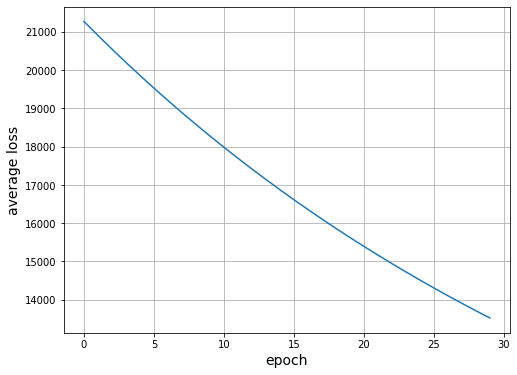

In [42]:
# Visualize learning curve
# plot the convergence of the estimated loss function
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

In [43]:
# Calcuate Accuracy
num_correct = 0.0
num_total = len(Xtest)
for i, (data, label) in enumerate(test_data):
   data = data.as_in_context(model_ctx)
   label = label.as_in_context(model_ctx)
   output = net(data)
   prediction = (nd.sign(output) + 1) / 2
   num_correct += nd.sum(prediction == label)
print("Accuracy: %0.3f (%s/%s)" % (num_correct.asscalar()/num_total, num_correct.asscalar(), num_total))

Accuracy: 0.999 (1604.0/1605)
